In [302]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.datasets import mnist #to import our dataset
from tensorflow.keras.models import Sequential, Model # imports our type of network
from tensorflow.keras.layers import Dense, Flatten,Conv2D, Input, Lambda, Layer, ReLU # imports our layers we want to use

from tensorflow.python.keras.losses import categorical_crossentropy #loss function
from tensorflow.python.keras.optimizers import Adam, SGD #optimisers
from tensorflow.python.keras.utils import to_categorical #some function for data preparation




In [303]:
from scipy.ndimage import rotate

def rotate_img(img, angle):
    #angle in degree
    return rotate(img, angle)

# number of classes of the mnist dataset
num_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28

# load mnist data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#prepare the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


example=np.reshape([rotate_img(x_train[0],0),rotate_img(x_train[0],90),rotate_img(x_train[0],180),rotate_img(x_train[0],270)],(4,28,28,1))

In [304]:
#create randomly rotation angles of 0,90,180 or 270 degrees for each image
angles_train = np.random.randint(0,4, size = x_train.shape[0])*90
angles_test = np.random.randint(0,4, size = x_test.shape[0])*90

#now rotate each image by the respective angle
for i in range(x_train.shape[0]):
    x_train[i] = rotate_img(x_train[i],angles_train[i])
for i in range(x_test.shape[0]):
    x_test[i] = rotate_img(x_test[i],angles_test[i])
    
x_train=x_train.reshape(len(x_train),28,28,1)
x_test=x_test.reshape(len(x_test),28,28,1)

In [314]:
input_network = Input(shape=(28,28))
x = Lambda(lambda x: tf.einsum('kij->kji',x))(input_network) #transpose
x = Lambda(lambda x: tf.reverse(x,[-2]))(x) #reverse ordering
model= Model(input_network,outputs=x)
opt = Adam(lr=0.0001)
model.compile(loss=categorical_crossentropy,optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "model_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_142 (InputLayer)       [(None, 28, 28)]          0         
_________________________________________________________________
lambda_47 (Lambda)           (None, 28, 28)            0         
_________________________________________________________________
lambda_48 (Lambda)           (None, 28, 28)            0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [316]:
pred=model.predict(x_train[:3,:,:,0])

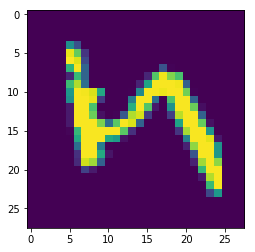

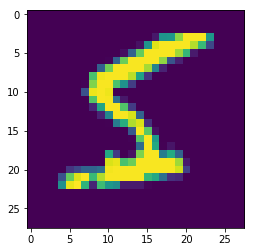

In [318]:
# Let's check our result:
plt.imshow(x_train[0,:,:,0])
plt.show()
plt.imshow(pred[0])
plt.show()

In [33]:
input_network = Input(shape=(28*28,))
x = Dense(100)(input_network)
m_bare= Model(input_network,outputs=x)
#opt = Adam(lr=0.0001)
#model.compile(loss=categorical_crossentropy,optimizer=Adam(), metrics=['accuracy'])
m_bare.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               78500     
Total params: 78,500
Trainable params: 78,500
Non-trainable params: 0
_________________________________________________________________


In [312]:
class MyDenseLayer(tf.keras.layers.Layer):
    def __init__(self, num_outputs):
        super(MyDenseLayer, self).__init__()
        self.num_outputs = num_outputs

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel", shape=[int(input_shape[-1]),self.num_outputs])
        self.bias = self.add_weight("bias", shape=[self.num_outputs])

    #def call(self, input):
    #    return tf.matmul(input, self.kernel)    
        
    def call(self, input):
        #wx=tf.matmul(input, self.kernel)
        wx=tf.einsum('ij,jn->in',input, self.kernel)
        return tf.add(wx, self.bias)

layer = MyDenseLayer(100)

In [313]:
#just a dense layer

layer = MyDenseLayer(200)

input_network = Input(shape=(28,28))
x=Flatten()(input_network)
x=layer(x)
m_all= Model(input_network,outputs=x)

#opt = Adam(lr=0.0001)
#m_all.compile(loss=categorical_crossentropy,optimizer=Adam(), metrics=['accuracy'])
m_all.summary()

Model: "model_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_141 (InputLayer)       [(None, 28, 28)]          0         
_________________________________________________________________
flatten_57 (Flatten)         (None, 784)               0         
_________________________________________________________________
my_dense_layer_19 (MyDenseLa (None, 200)               157000    
Total params: 157,000
Trainable params: 157,000
Non-trainable params: 0
_________________________________________________________________


In [322]:
#how to get to this function
# got to work a convolutional layer as a custom layer
# got to work 4 convolutional layers with the same weight
# implement the transpose and reverse ordering on the weights (check dimension of the weights model.layers[1].get_weights())

class RotatedConv(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides=None, padding=None, activation=None,use_bias=False, **kwargs):
        super(RotatedConv, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.activation = activation
        self.use_bias = use_bias

    def build(self, input_shape):
        self.conv = tf.keras.layers.Conv2D(
           self.filters,
           self.kernel_size,
           padding=self.padding,use_bias=self.use_bias
       )

    def call(self, inputs, **kwargs):
        x1 = self.conv(inputs)
        w2=self.conv.weights[0]
        w2=tf.einsum('ijlm->jilm',w2)
        w2=tf.reverse(w2,[-4])
        w3=w2
        w3=tf.einsum('ijlm->jilm',w3)
        w3=tf.reverse(w3,[-4])
        w4=w3
        w4=tf.einsum('ijlm->jilm',w4)
        w4=tf.reverse(w4,[-4])
        x2 = tf.nn.conv2d(
                inputs,w2, 
                padding=self.padding,
                strides=self.strides)
        x3 = tf.nn.conv2d(
                inputs,
                w3, 
                padding=self.padding,
                strides=self.strides)
        x4 = tf.nn.conv2d(
                inputs,
                w4, 
                padding=self.padding,
                strides=self.strides)
        return Lambda(lambda x: tf.stack([x[0],x[1],x[2],x[3]],axis=-1))([x1,x2,x3,x4])

In [323]:
input_network = Input(shape=(28,28,1))
#x=Flatten()(input_network)
x=RotatedConv(1,(28,28),padding='VALID')(input_network)
x=Flatten()(x)
#x=ReLU()(x)
m_all= Model(input_network,outputs=x)

#opt = Adam(lr=0.0001)
#m_all.compile(loss=categorical_crossentropy,optimizer=Adam(), metrics=['accuracy'])
m_all.summary()


m_all.predict(example)

Model: "model_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_144 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
rotated_conv_3 (RotatedConv) (None, 1, 1, 1, 4)        784       
_________________________________________________________________
flatten_59 (Flatten)         (None, 4)                 0         
Total params: 784
Trainable params: 784
Non-trainable params: 0
_________________________________________________________________


array([[-0.1143059 , -0.09360655, -0.2583987 , -0.23722228],
       [-0.23722228, -0.11430588, -0.09360659, -0.25839874],
       [-0.25839877, -0.23722225, -0.11430587, -0.09360654],
       [-0.09360658, -0.25839877, -0.23722225, -0.11430591]],
      dtype=float32)

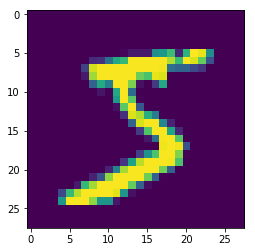

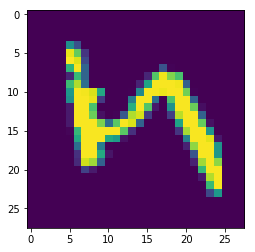

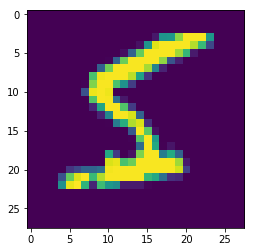

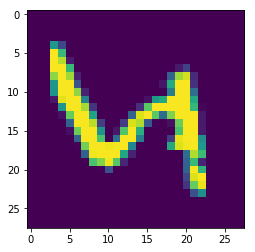

In [321]:
for i in range(4):
    plt.imshow(example[i].reshape(28,28))
    plt.show()

In [324]:
input_network = Input(shape=(28,28,1))
#x=Flatten()(input_network)
x=RotatedConv(100,(28,28),padding='VALID')(input_network)
x=Flatten()(x)
x=ReLU()(x)
x=Dense(100,activation='relu')(x)
x=Dense(num_classes,activation='softmax')(x)
m_all= Model(input_network,outputs=x)

opt = Adam(lr=0.0001)
m_all.compile(loss=categorical_crossentropy,optimizer=Adam(), metrics=['accuracy'])
m_all.summary()


Model: "model_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_145 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
rotated_conv_4 (RotatedConv) (None, 1, 1, 100, 4)      78400     
_________________________________________________________________
flatten_60 (Flatten)         (None, 400)               0         
_________________________________________________________________
re_lu_9 (ReLU)               (None, 400)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               40100     
_________________________________________________________________
dense_15 (Dense)             (None, 10)                1010      
Total params: 119,510
Trainable params: 119,510
Non-trainable params: 0
____________________________________________________

In [325]:
history=m_all.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 21s 353us/sample - loss: 0.6809 - acc: 0.7901 - val_loss: 0.3329 - val_acc: 0.9011
Epoch 2/20
60000/60000 [==============================] - 30s 504us/sample - loss: 0.2614 - acc: 0.9230 - val_loss: 0.2190 - val_acc: 0.9332
Epoch 3/20
60000/60000 [==============================] - 24s 402us/sample - loss: 0.1869 - acc: 0.9439 - val_loss: 0.2149 - val_acc: 0.9320
Epoch 4/20
60000/60000 [==============================] - 24s 398us/sample - loss: 0.1439 - acc: 0.9564 - val_loss: 0.1837 - val_acc: 0.9423
Epoch 5/20
60000/60000 [==============================] - 19s 313us/sample - loss: 0.1174 - acc: 0.9647 - val_loss: 0.1735 - val_acc: 0.9480
Epoch 6/20
60000/60000 [==============================] - 19s 311us/sample - loss: 0.0992 - acc: 0.9695 - val_loss: 0.1581 - val_acc: 0.9533
Epoch 7/20
60000/60000 [==============================] - 19s 312us/sample - loss: 0.0830 - acc: 0.9742 

KeyboardInterrupt: 

In [287]:
np.shape(x_train)

(60000, 28, 28)

In [294]:
input_network = Input(shape=(28,28,1))
#x=Flatten()(input_network)
x=Conv2D(100,(28,28),padding='VALID',use_bias=False)(input_network)
x=Flatten()(x)
x=ReLU()(x)
x=Dense(100,activation='relu')(x)
x=Dense(num_classes,activation='softmax')(x)
m_2= Model(input_network,outputs=x)

opt = Adam(lr=0.0001)
m_2.compile(loss=categorical_crossentropy,optimizer=Adam(), metrics=['accuracy'])
m_2.summary()

Model: "model_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_134 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 1, 1, 100)         78400     
_________________________________________________________________
flatten_50 (Flatten)         (None, 100)               0         
_________________________________________________________________
re_lu_7 (ReLU)               (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1010      
Total params: 89,510
Trainable params: 89,510
Non-trainable params: 0
______________________________________________________

In [295]:
history=m_2.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 48us/sample - loss: 0.8906 - acc: 0.7203 - val_loss: 0.5749 - val_acc: 0.8280
Epoch 2/20
60000/60000 [==============================] - 2s 37us/sample - loss: 0.4849 - acc: 0.8547 - val_loss: 0.4109 - val_acc: 0.8750
Epoch 3/20
60000/60000 [==============================] - 2s 36us/sample - loss: 0.3476 - acc: 0.8960 - val_loss: 0.3360 - val_acc: 0.8993
Epoch 4/20
60000/60000 [==============================] - 2s 40us/sample - loss: 0.2730 - acc: 0.9186 - val_loss: 0.2909 - val_acc: 0.9119
Epoch 5/20
60000/60000 [==============================] - 2s 37us/sample - loss: 0.2296 - acc: 0.9306 - val_loss: 0.2731 - val_acc: 0.9151
Epoch 6/20
60000/60000 [==============================] - 2s 39us/sample - loss: 0.1978 - acc: 0.9403 - val_loss: 0.2569 - val_acc: 0.9222
Epoch 7/20
60000/60000 [==============================] - 2s 37us/sample - loss: 0.1749 - acc: 0.9461 - val_loss: 0.

In [296]:
input_network = Input(shape=(28,28,1))
#x=Flatten()(input_network)
x=Conv2D(400,(28,28),padding='VALID',use_bias=False)(input_network)
x=Flatten()(x)
x=ReLU()(x)
x=Dense(100,activation='relu')(x)
x=Dense(num_classes,activation='softmax')(x)
m_3= Model(input_network,outputs=x)

opt = Adam(lr=0.0001)
m_3.compile(loss=categorical_crossentropy,optimizer=Adam(), metrics=['accuracy'])
m_3.summary()

Model: "model_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_135 (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 1, 1, 400)         313600    
_________________________________________________________________
flatten_51 (Flatten)         (None, 400)               0         
_________________________________________________________________
re_lu_8 (ReLU)               (None, 400)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               40100     
_________________________________________________________________
dense_13 (Dense)             (None, 10)                1010      
Total params: 354,710
Trainable params: 354,710
Non-trainable params: 0
____________________________________________________

In [298]:
history=m_3.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 5s 82us/sample - loss: 0.0157 - acc: 0.9948 - val_loss: 0.2387 - val_acc: 0.9535
Epoch 2/20
60000/60000 [==============================] - 5s 79us/sample - loss: 0.0222 - acc: 0.9923 - val_loss: 0.2489 - val_acc: 0.9520
Epoch 3/20
60000/60000 [==============================] - 5s 89us/sample - loss: 0.0146 - acc: 0.9949 - val_loss: 0.2636 - val_acc: 0.9487
Epoch 4/20
60000/60000 [==============================] - 7s 108us/sample - loss: 0.0182 - acc: 0.9940 - val_loss: 0.2809 - val_acc: 0.9485
Epoch 5/20
60000/60000 [==============================] - 6s 101us/sample - loss: 0.0165 - acc: 0.9947 - val_loss: 0.2606 - val_acc: 0.9497
Epoch 6/20
42368/60000 [====================>.........] - ETA: 1s - loss: 0.0104 - acc: 0.9967

KeyboardInterrupt: 

In [328]:
input_network = Input(shape=(28,28,1))
x=Dense(100,activation='relu')(x)
x=Dense(num_classes,activation='softmax')(x)
m_4= Model(input_network,outputs=x)

opt = Adam(lr=0.0001)
m_4.compile(loss=categorical_crossentropy,optimizer=Adam(), metrics=['accuracy'])
m_4.summary()

ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_146:0", shape=(?, 28, 28, 1), dtype=float32) at layer "input_146". The following previous layers were accessed without issue: []

In [327]:
history=m_4.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 4s 71us/sample - loss: 0.9268 - acc: 0.7178 - val_loss: 0.6018 - val_acc: 0.8231
Epoch 2/20
60000/60000 [==============================] - 3s 51us/sample - loss: 0.5139 - acc: 0.8547 - val_loss: 0.4398 - val_acc: 0.8721
Epoch 3/20
60000/60000 [==============================] - 4s 59us/sample - loss: 0.3873 - acc: 0.8896 - val_loss: 0.3640 - val_acc: 0.8923
Epoch 4/20
60000/60000 [==============================] - 4s 66us/sample - loss: 0.3203 - acc: 0.9075 - val_loss: 0.3270 - val_acc: 0.9034
Epoch 5/20
60000/60000 [==============================] - 3s 57us/sample - loss: 0.2757 - acc: 0.9202 - val_loss: 0.2971 - val_acc: 0.9090
Epoch 6/20
60000/60000 [==============================] - 4s 62us/sample - loss: 0.2450 - acc: 0.9289 - val_loss: 0.2942 - val_acc: 0.9126
Epoch 7/20
60000/60000 [==============================] - 4s 73us/sample - loss: 0.2204 - acc: 0.9366 - val_loss: 0.